# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import joblib

import warnings
warnings.filterwarnings('ignore')

# Data Prepocessing

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/wahyughifari/Food-Delivery-Times/refs/heads/main/Food_Delivery_Times.csv')
df

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68
...,...,...,...,...,...,...,...,...,...
995,107,8.50,Clear,High,Evening,Car,13,3.0,54
996,271,16.28,Rainy,Low,Morning,Scooter,8,9.0,71
997,861,15.62,Snowy,High,Evening,Scooter,26,2.0,81
998,436,14.17,Clear,Low,Afternoon,Bike,8,0.0,55


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


## Duplicate

In [4]:
# duplicate
df.duplicated().sum()

np.int64(0)

## Missing Value

In [5]:
# missing value
df.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,30
Traffic_Level,30
Time_of_Day,30
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,30
Delivery_Time_min,0


In [6]:
# categorical
for col in ['Weather', 'Traffic_Level', 'Time_of_Day']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# numerical
df['Courier_Experience_yrs'].fillna(df['Courier_Experience_yrs'].median(), inplace=True)

In [7]:
df.isnull().sum()

,0
Order_ID,0
Distance_km,0
Weather,0
Traffic_Level,0
Time_of_Day,0
Vehicle_Type,0
Preparation_Time_min,0
Courier_Experience_yrs,0
Delivery_Time_min,0


## Outlier

In [8]:
# skewness
for col in df.columns:
  if df[col].dtype == 'int64' or df[col].dtype == 'float64':
    print(f'{col}: {df[col].skew()}')

Order_ID: 0.0
Distance_km: 0.038840474919290116
Preparation_Time_min: 0.030008161330597263
Courier_Experience_yrs: -0.04262066812874942
Delivery_Time_min: 0.5072511816152696


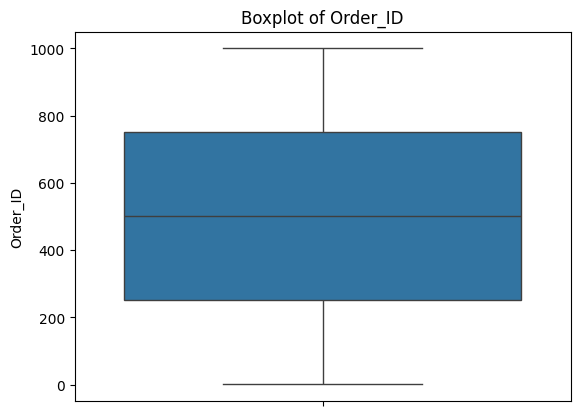

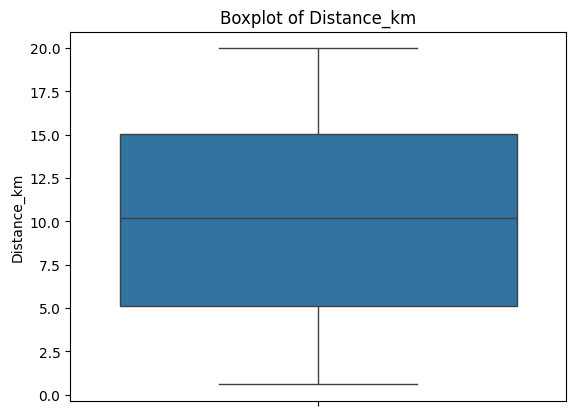

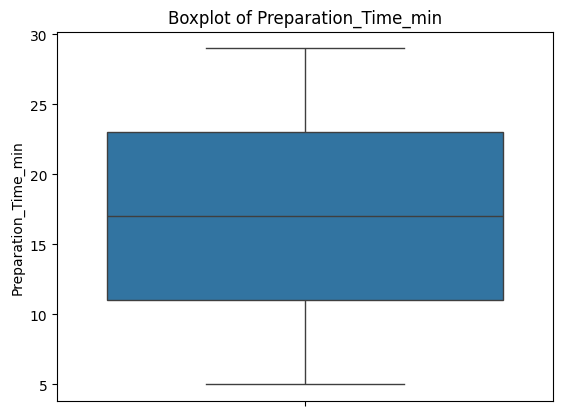

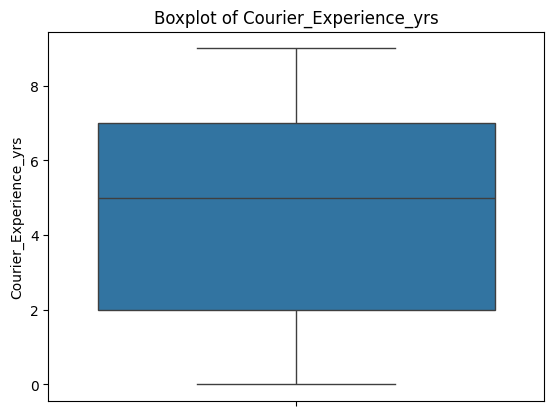

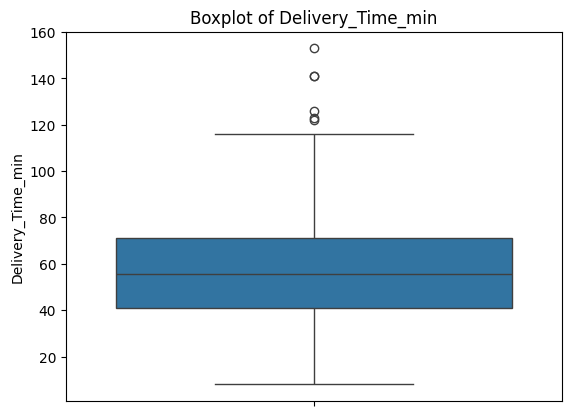

In [9]:
# boxplot outlier
for col in df.columns:
  if df[col].dtype == 'int64' or df[col].dtype == 'float64':
    fig, ax = plt.subplots()
    sns.boxplot(df[col], ax=ax)
    plt.title(f'Boxplot of {col}')
    plt.show()

In [10]:
# detect outliers
def detect_outliers_all(df):
    outlier_summary = {}

    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]

        outlier_summary[col] = {
            'outlier_count': len(outliers),
            'lower_bound': lower,
            'upper_bound': upper
        }

    return pd.DataFrame(outlier_summary).T.sort_values(by='outlier_count', ascending=False)


outlier_info = detect_outliers_all(df)
print(outlier_info)

                        outlier_count  lower_bound  upper_bound
Delivery_Time_min                 6.0     -4.00000    116.00000
Order_ID                          0.0   -498.50000   1499.50000
Distance_km                       0.0     -9.76375     29.88625
Preparation_Time_min              0.0     -7.00000     41.00000
Courier_Experience_yrs            0.0     -5.50000     14.50000


# Exploratory Data Analyst

## Statistic Descriptive and correlation

In [11]:
# statistic descriptive
print(df.describe())

          Order_ID  Distance_km  Preparation_Time_min  Courier_Experience_yrs  \
count  1000.000000  1000.000000           1000.000000             1000.000000   
mean    500.500000    10.059970             16.982000                4.592000   
std     288.819436     5.696656              7.204553                2.871198   
min       1.000000     0.590000              5.000000                0.000000   
25%     250.750000     5.105000             11.000000                2.000000   
50%     500.500000    10.190000             17.000000                5.000000   
75%     750.250000    15.017500             23.000000                7.000000   
max    1000.000000    19.990000             29.000000                9.000000   

       Delivery_Time_min  
count        1000.000000  
mean           56.732000  
std            22.070915  
min             8.000000  
25%            41.000000  
50%            55.500000  
75%            71.000000  
max           153.000000  


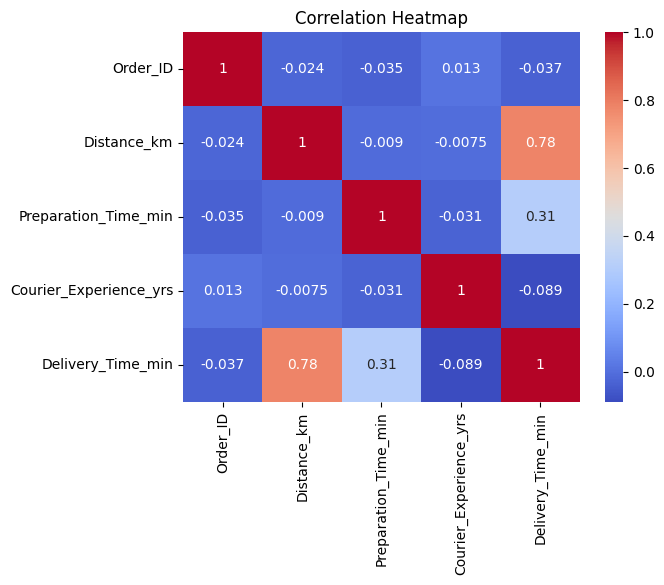

In [12]:
# heatmap correlation
numerical_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [13]:
numerical_df.corr()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
Order_ID,1.000000,-0.024483,-0.035100,0.012698,-0.036650
Distance_km,-0.024483,1.000000,-0.009037,-0.007534,0.780998
Preparation_Time_min,-0.035100,-0.009037,1.000000,-0.030842,0.307350
Courier_Experience_yrs,0.012698,-0.007534,-0.030842,1.000000,-0.089111
Delivery_Time_min,-0.036650,0.780998,0.307350,-0.089111,1.000000


## Distribution & Outlier: Delivery_Time_min

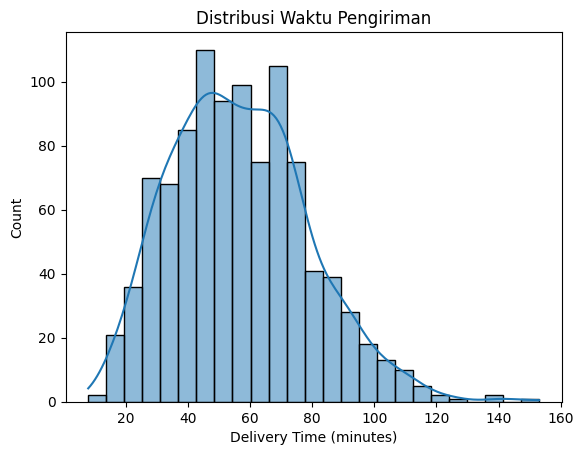

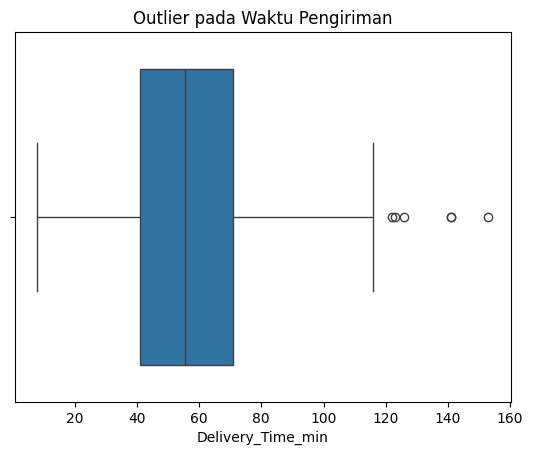

In [14]:
# Histogram
sns.histplot(df['Delivery_Time_min'], kde=True)
plt.title("Distribusi Waktu Pengiriman")
plt.xlabel("Delivery Time (minutes)")
plt.show()

# Boxplot
sns.boxplot(x=df['Delivery_Time_min'])
plt.title("Outlier pada Waktu Pengiriman")
plt.show()

## Delivery Distance and Time

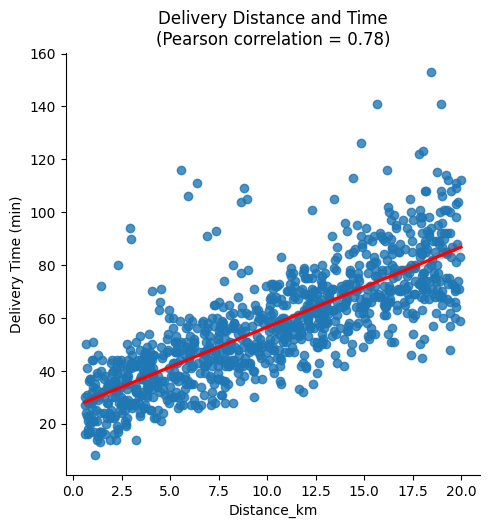

In [15]:
dis = df['Distance_km'].corr(df['Delivery_Time_min'])

sns.lmplot(x='Distance_km', y='Delivery_Time_min', data=df, line_kws={'color': 'red'})
plt.title(f"Delivery Distance and Time\n(Pearson correlation = {dis:.2f})")
plt.ylabel("Delivery Time (min)")
plt.show()

## Time of Day vs Average Delivery Time

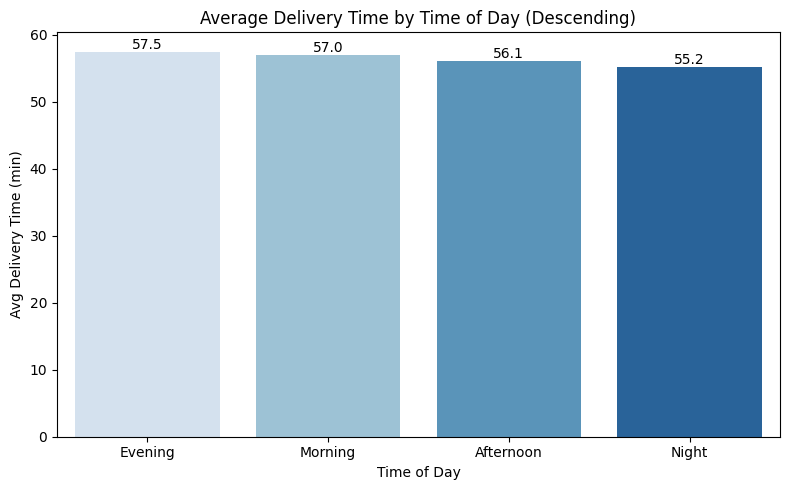

In [16]:
# Time of Day vs Average Delivery Time
avg_time = df.groupby("Time_of_Day")["Delivery_Time_min"].mean().sort_values(ascending=False).reset_index()

# Plot in descending order
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='Time_of_Day',
    y='Delivery_Time_min',
    data=avg_time,
    palette='Blues'
)

# Title and labels
plt.title("Average Delivery Time by Time of Day (Descending)")
plt.xlabel("Time of Day")
plt.ylabel("Avg Delivery Time (min)")

# Add value labels on each bar
for p in ax.patches:
    value = p.get_height()
    ax.annotate(f'{value:.1f}',
                (p.get_x() + p.get_width() / 2, value),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [17]:
avg_time

,Time_of_Day,Delivery_Time_min
0,Evening,57.481229
1,Morning,57.011834
2,Afternoon,56.080986
3,Night,55.211765


##  Average Delivery Time Based on Weather

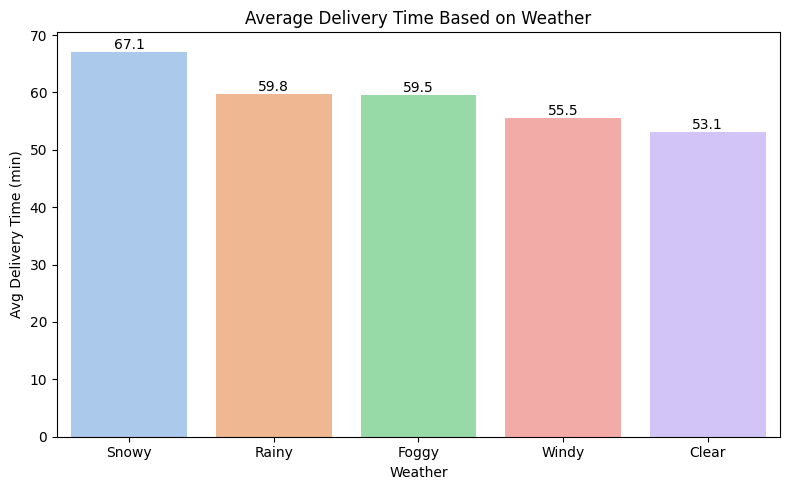

In [18]:
# Average Delivery Time Based on Weather
mean_weather = df.groupby("Weather")["Delivery_Time_min"].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(x="Weather", y="Delivery_Time_min", data=mean_weather, palette="pastel")
plt.title("Average Delivery Time Based on Weather")
plt.ylabel("Avg Delivery Time (min)")
plt.xlabel("Weather")

for index, row in mean_weather.iterrows():
    ax.text(index, row["Delivery_Time_min"] + 0.01, f"{row['Delivery_Time_min']:.1f}",
            ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [19]:
mean_weather

,Weather,Delivery_Time_min
0,Snowy,67.113402
1,Rainy,59.794118
2,Foggy,59.466019
3,Windy,55.458333
4,Clear,53.150000


## Traffic Level vs Delivery Time

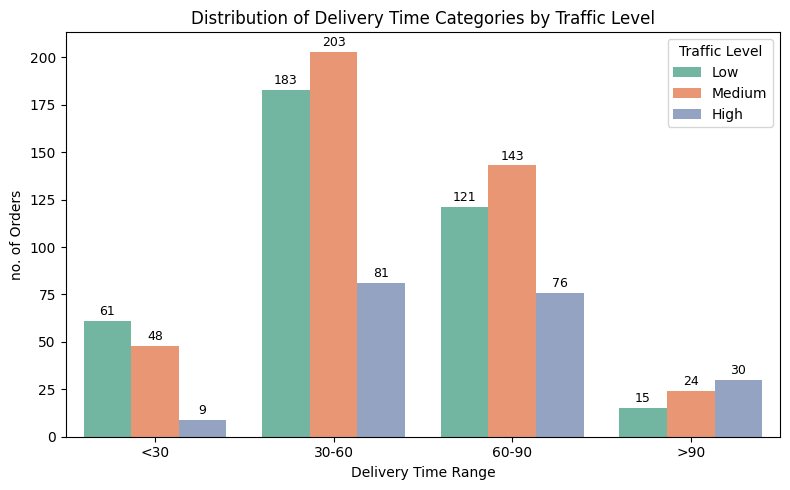

In [20]:
# Binning Delivery Time
df['Delivery_Time_Bin'] = pd.cut(df['Delivery_Time_min'], bins=[0, 30, 60, 90, 120], labels=['<30', '30-60', '60-90', '>90'])

# Traffic Level distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Delivery_Time_Bin', hue='Traffic_Level', data=df, palette='Set2')
plt.title("Distribution of Delivery Time Categories by Traffic Level")
plt.xlabel("Delivery Time Range")
plt.ylabel("no. of Orders")
plt.legend(title="Traffic Level")

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2, fontsize=9)

plt.tight_layout()
plt.show()

In [21]:
pd.crosstab(df['Delivery_Time_Bin'], df['Traffic_Level'])

Traffic_Level,High,Low,Medium
Delivery_Time_Bin,,,
<30,9,61,48
30-60,81,183,203
60-90,76,121,143
>90,30,15,24


## Average Delivery Time by Vehicle Type

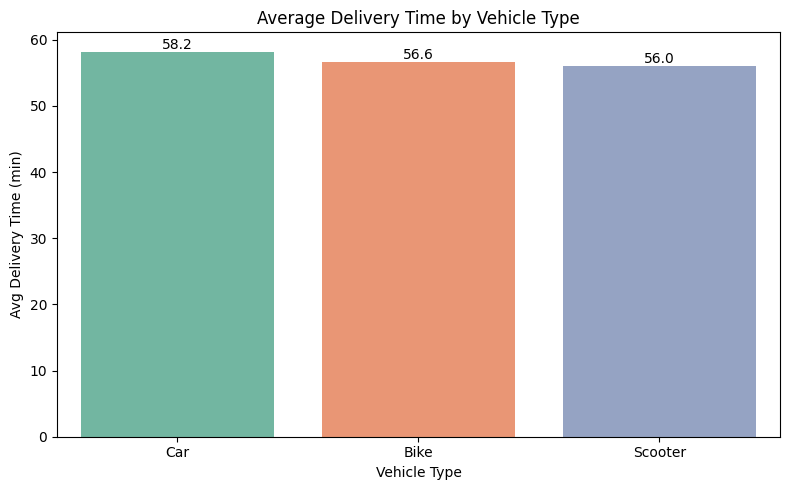

In [22]:
# Average Delivery Time by Vehicle Type
avg_vehicle = df.groupby("Vehicle_Type")["Delivery_Time_min"].mean().sort_values(ascending=False).reset_index()

# Plot bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='Vehicle_Type',
    y='Delivery_Time_min',
    data=avg_vehicle,
    palette='Set2'
)

# Title and labels
plt.title("Average Delivery Time by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Avg Delivery Time (min)")

# Add value labels on bars
for p in ax.patches:
    value = p.get_height()
    ax.annotate(f'{value:.1f}',
                (p.get_x() + p.get_width() / 2, value),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
avg_vehicle

,Vehicle_Type,Delivery_Time_min
0,Car,58.200000
1,Bike,56.574553
2,Scooter,56.046358


## Preparation Time vs Delivery Time

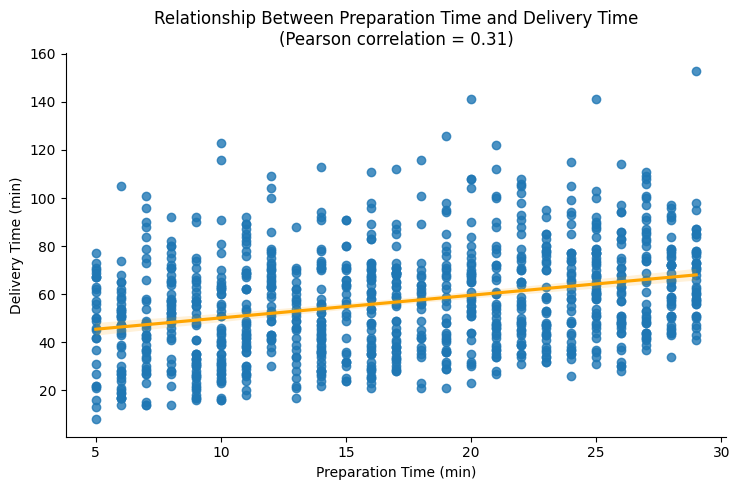

In [24]:
corr = df['Preparation_Time_min'].corr(df['Delivery_Time_min'])

sns.lmplot(
    x='Preparation_Time_min',
    y='Delivery_Time_min',
    data=df,
    line_kws={'color': 'orange'},
    height=5, aspect=1.5
)

plt.title(f"Relationship Between Preparation Time and Delivery Time\n(Pearson correlation = {corr:.2f})")
plt.xlabel("Preparation Time (min)")
plt.ylabel("Delivery Time (min)")
plt.tight_layout()
plt.show()

In [25]:
corr

np.float64(0.30734996261566927)

## Average Delivery Time vs Courier Experience

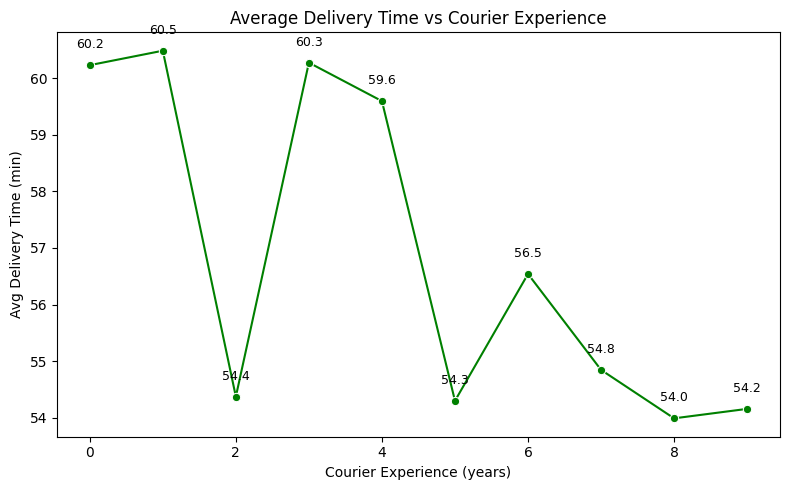

In [26]:
# Average Delivery Time vs Courier Experience

mean_exp = df.groupby('Courier_Experience_yrs')['Delivery_Time_min'].mean().reset_index().sort_values('Courier_Experience_yrs')

# Plot line chart
plt.figure(figsize=(8,5))
ax = sns.lineplot(
    x='Courier_Experience_yrs',
    y='Delivery_Time_min',
    data=mean_exp,
    marker='o',
    color='green'
)

# Title and labels
plt.title("Average Delivery Time vs Courier Experience")
plt.xlabel("Courier Experience (years)")
plt.ylabel("Avg Delivery Time (min)")

# Add value labels at each point
for i, row in mean_exp.iterrows():
    plt.text(row['Courier_Experience_yrs'], row['Delivery_Time_min'] + 0.3,
             f"{row['Delivery_Time_min']:.1f}",
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [27]:
mean_exp

,Courier_Experience_yrs,Delivery_Time_min
0,0.0,60.230769
1,1.0,60.485981
2,2.0,54.373737
3,3.0,60.275000
4,4.0,59.595745
5,5.0,54.300000
6,6.0,56.541284
7,7.0,54.846154
8,8.0,53.990099
9,9.0,54.157407


# Feature Engineering

## Handling Outlier

In [28]:
# detect outliers
def detect_outliers_all(df):
    outlier_summary = {}

    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]

        outlier_summary[col] = {
            'outlier_count': len(outliers),
            'lower_bound': lower,
            'upper_bound': upper
        }

    return pd.DataFrame(outlier_summary).T.sort_values(by='outlier_count', ascending=False)


outlier_info = detect_outliers_all(df)
print(outlier_info)

                        outlier_count  lower_bound  upper_bound
Delivery_Time_min                 6.0     -4.00000    116.00000
Order_ID                          0.0   -498.50000   1499.50000
Distance_km                       0.0     -9.76375     29.88625
Preparation_Time_min              0.0     -7.00000     41.00000
Courier_Experience_yrs            0.0     -5.50000     14.50000


In [29]:
# winsorizing
df['Delivery_Time_min'] = df['Delivery_Time_min'].clip(lower=0, upper=116)
print("lower:", df['Delivery_Time_min'].min())
print("upper:", df['Delivery_Time_min'].max())

lower: 8
upper: 116


## Encoding

In [30]:
# Ome-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'], drop_first=True)

In [31]:
# Columns dropping
df_encoded = df_encoded.drop(columns=['Order_ID', 'Delivery_Time_Bin'])

## Feature Scalling

In [32]:
# scalling
numerical_cols = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

## Features splitting

In [33]:
# Features splitting
X = df_encoded.drop(columns='Delivery_Time_min')
y = df_encoded['Delivery_Time_min']

In [34]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Variance Inflation Factor (VIF)

In [35]:
# VIF
X_vif = X.copy()
X_vif = X_vif.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                   feature       VIF
8     Traffic_Level_Medium  2.048918
7        Traffic_Level_Low  1.896833
10     Time_of_Day_Morning  1.791823
9      Time_of_Day_Evening  1.675702
13    Vehicle_Type_Scooter  1.468549
12        Vehicle_Type_Car  1.340445
4            Weather_Rainy  1.323866
11       Time_of_Day_Night  1.184776
3            Weather_Foggy  1.168220
5            Weather_Snowy  1.167813
6            Weather_Windy  1.148270
2   Courier_Experience_yrs  1.013796
0              Distance_km  1.011331
1     Preparation_Time_min  1.006188


# Modelling and Evaluation

## Baseline Model: Linear Regression

In [36]:
# Train Model
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [37]:
# Model evaluation
y_pred = model.predict(X_test)

print("Linear Regression:")
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Linear Regression:
MAE:  5.850747130883324
R² Score: 0.8302260748706084
RMSE: 8.686178744960015


In [43]:
# Prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R2 score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE
rmse_train_linreg = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_linreg = np.sqrt(mean_squared_error(y_test, y_test_pred))

# MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Training R2: {r2_train:.4f}, RMSE: {rmse_train_linreg:.2f}, MAE: {mae_train:.2f}")
print(f"Testing R2: {r2_test:.4f}, RMSE: {rmse_test_linreg:.2f}, , MAE: {mae_test:.2f}")

Training R2: 0.7788, RMSE: 10.27, MAE: 6.48
Testing R2: 0.8302, RMSE: 8.69, , MAE: 5.85


## Model Alternative: Ridge Regression

In [44]:
# Train Model
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)

Ridge(random_state=42)

In [56]:
# Mode evaluation
y_pred_ridge = ridge_model.predict(X_test)

r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print("Ridge Regression:")
print(f"Ridge Regression MAE: {mae_ridge:.2f}")
print(f"Ridge Regression R² Score: {r2_ridge:.4f}")
print(f"Ridge Regression RMSE: {rmse_ridge:.2f}")

Ridge Regression:
Ridge Regression MAE: 5.86
Ridge Regression R² Score: 0.8296
Ridge Regression RMSE: 8.70


In [59]:
# Prediction
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

# R2 score
r2_train_ridge = r2_score(y_train, y_train_pred)
r2_test_ridge = r2_score(y_test, y_test_pred)

# RMSE
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred))

# MAE
mae_train_ridge = mean_absolute_error(y_train, y_train_pred)
mae_test_ridge = mean_absolute_error(y_test, y_test_pred)

print(f"Training R2: {r2_train_ridge:.4f}, RMSE: {rmse_train_ridge:.2f}, MAE: {mae_train_ridge:.2f}")
print(f"Testing R2: {r2_test_ridge:.4f}, RMSE: {rmse_test_ridge:.2f}, MAE: {mae_test_ridge:.2f}")

Training R2: 0.7788, RMSE: 10.27, MAE: 6.48
Testing R2: 0.8296, RMSE: 8.70, MAE: 5.86


## Model Alternative: Lasso Regression

In [60]:
# Train model
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.1, random_state=42)

In [62]:
# Model evaluation
y_pred_lasso = lasso_model.predict(X_test)

r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

print("Lasso Regression:")
print(f"Lasso Regression MAE: {mae_lasso:.2f}")
print(f"Lasso Regression R² Score: {r2_lasso:.4f}")
print(f"Lasso Regression RMSE: {rmse_lasso:.2f}")

Lasso Regression:
Lasso Regression MAE: 6.04
Lasso Regression R² Score: 0.8221
Lasso Regression RMSE: 8.89


In [63]:
# Prediction
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

# R2 score
r2_train_lasso = r2_score(y_train, y_train_pred)
r2_test_lasso = r2_score(y_test, y_test_pred)

# RMSE
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred))

# MAE
mae_train_lasso = mean_absolute_error(y_train, y_train_pred)
mae_test_lasso = mean_absolute_error(y_test, y_test_pred)

print(f"Training R2: {r2_train_lasso:.4f}, RMSE: {rmse_train_lasso:.2f}, MAE: {mae_train_lasso:.2f}")
print(f"Testing R2: {r2_test_lasso:.4f}, RMSE: {rmse_test_lasso:.2f}, MAE: {mae_test_lasso:.2f}")

Training R2: 0.7764, RMSE: 10.33, MAE: 6.54
Testing R2: 0.8221, RMSE: 8.89, MAE: 6.04


## Model Alternative: Random Forest Regression

In [64]:
# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [66]:
# Model evaluation
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest Regression:")
print(f"Random Forest Regression MAE: {mae_rf:.2f}")
print(f"Random Forest R² Score: {r2_rf:.4f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")

Random Forest Regression:
Random Forest Regression MAE: 7.00
Random Forest R² Score: 0.7666
Random Forest RMSE: 10.18


In [67]:
# Prediction
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# R2 score
r2_train_rf = r2_score(y_train, y_train_pred)
r2_test_rf = r2_score(y_test, y_test_pred)

# RMSE
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred))

# MAE
mae_train_rf = mean_absolute_error(y_train, y_train_pred)
mae_test_rf = mean_absolute_error(y_test, y_test_pred)

print(f"Training R2: {r2_train_rf:.4f}, RMSE: {rmse_train_rf:.2f}, MAE: {mae_train_rf:.2f}")
print(f"Testing R2: {r2_test_rf:.4f}, RMSE: {rmse_test_rf:.2f}, MAE: {mae_test_rf:.2f}")

Training R2: 0.9566, RMSE: 4.55, MAE: 2.98
Testing R2: 0.7666, RMSE: 10.18, MAE: 7.00


## Hyperparameter Tuning: Ridge Regression

In [68]:
# param grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

ridge = Ridge()
grid = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [69]:
# best ridge
best_alpha = grid.best_params_['alpha']
print("Best alpha:", best_alpha)

best_ridge = grid.best_estimator_

Best alpha: 1


In [72]:
# evaluation
y_pred = best_ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Tuned Ridge Regression R² Score:", round(r2, 4))
print("Tuned Ridge Regression RMSE:", round(rmse, 2))
print("Tuned Ridge Regression MAE:", round(mae, 2))

Tuned Ridge Regression R² Score: 0.8296
Tuned Ridge Regression RMSE: 8.7
Tuned Ridge Regression MAE: 5.86


In [73]:
# Prediction
y_train_pred = best_ridge.predict(X_train)

# R2 score
r2_train_tuning_ridge = r2_score(y_train, y_train_pred)

# RMSE
rmse_train_tuning_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred))

# MAE
mae_train_tuning_ridge = mean_absolute_error(y_train, y_train_pred)

print(f"Training R2: {r2_train_tuning_ridge:.4f}, RMSE: {rmse_train_tuning_ridge:.2f}, MAE: {mae_train_tuning_ridge:.2f}")


Training R2: 0.7788, RMSE: 10.27, MAE: 6.48


# Saving Model

In [75]:
# scaling
joblib.dump(scaler, 'scaler.pkl')

# best model
joblib.dump(model, 'linear_model.pkl')

# columns
joblib.dump(X_train.columns.tolist(), 'columns.pkl')

['columns.pkl']

In [76]:
df.to_csv('eda_dataset.csv', index=False)